In [1]:
# packages

In [1]:
from __future__ import print_function, division
import os

from IPython import display
import sys
import importlib
import time
from tqdm import tqdm

import torch

import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math

import healpy as hp

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors

In [2]:
import fermipy
from fermipy.utils import make_psf_kernel

import astropy
from astropy import coordinates as coords
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

from DynGenModels.dynamics.nf.normflows import NormalizingFlow
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS 
from DynGenModels.configs.fermi_configs import FermiGCE_MAF_RQS_NormFlow as Configs

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.trainer.trainer import DynGenModelTrainer

from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData, PreProcessFermiData

In [3]:
#Load background pseudodata

In [3]:
background_folder = '/home/mb1403/GCE/ilias_backgrounds/GALACTIC_DIFFUSE_EMISSION_MAPS_0p25deg/'
pimap = background_folder+'pi0_0a_Map_flux_E_50-814008_MeV_InnerGalaxy_60x60.fits'
ICSmap = background_folder+'ICS_0a_Map_flux_E_50-814008_MeV_InnerGalaxy_60x60.fits'
bremmap = background_folder+'bremss_0a_Map_flux_E_50-814008_MeV_InnerGalaxy_60x60.fits'
isomap = '/home/mb1403/GCE/ilias_backgrounds/Isotropic_flux_E_50-814009_MeV_Cartesian.fits'
bubblesmap = '/home/mb1403/GCE/ilias_backgrounds/Bubbles_flux_E_50-814009_MeV_Cartesian.fits'

#this is the lower and upper bounds of the energy bins
energy_bins = np.array([43.8587, 57.0013,74.082,96.2812,125.133,162.629,211.362,274.698, 
                        357.014,463.995,603.034,783.737,1018.59,1323.82,1720.51,2236.07,
                        2906.12,3776.96,4908.75,6379.69,8291.4,10776.0,14005.1,18201.8,
                        23656.1,30744.8,39957.6,51931.2,67492.7,87717.4,114002.0,148164.0,
                        192562.0,250265.0,325258.0,422724.0,549396.0,714027.0,927989.0])
#bin centers
energy_bins_center = np.logspace( np.log10(50),np.log10(814008.272176),38)
energy_delta = (energy_bins[1:]-energy_bins[:-1])

pidata = fits.open(pimap)
ICSdata = fits.open(ICSmap)
bremdata = fits.open(bremmap)
isodata = fits.open(isomap)
bubblesdata = fits.open(bubblesmap)

totalbackground = (bubblesdata[0].data+isodata[0].data+
                   bremdata[0].data+pidata[0].data+ICSdata[0].data)

xpoints = np.linspace(30,-30,241)
ypoints = np.linspace(30,-30,241)
xpoints = 0.5*(xpoints[:-1]+xpoints[1:])
ypoints = 0.5*(ypoints[:-1]+ypoints[1:])

#matches plots of 2112.09706
xmesh,ymesh = np.meshgrid(xpoints,ypoints)
xmesh = -xmesh
ymesh = -ymesh

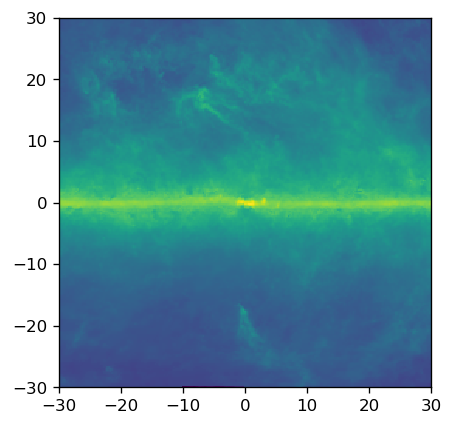

In [4]:
fig,ax = plt.subplots(1,1,figsize=(4,4), dpi= 120)
ax.pcolor(xmesh,ymesh,np.log10(pidata[0].data[0]))

In [5]:
exposure_file = background_folder+'ExposureDEnergyMapsInnerGalaxy_01degBins_60x60_E_50-814009_MeV_Cartesian.fits'
exposure_map = fits.open(exposure_file)

xpoints_exp = np.linspace(30,-30,601)
ypoints_exp = np.linspace(30,-30,601)
xpoints_exp = 0.5*(xpoints_exp[:-1]+xpoints_exp[1:])
ypoints_exp = 0.5*(ypoints_exp[:-1]+ypoints_exp[1:])

#matches plots of 2112.09706
xmesh_exp,ymesh_exp = np.meshgrid(xpoints_exp,ypoints_exp)
xmesh_exp = -xmesh_exp
ymesh_exp = -ymesh_exp

solid_angle_factor = np.abs(np.cos(ymesh_exp*np.pi/180))*(0.1*np.pi/180)**2

exposure_data = np.zeros([38,240,240])

for i,_ in enumerate(xmesh[0]):
    for j,_ in enumerate(ymesh[:,0]):
        indices = np.unravel_index( np.argmin( (xmesh[j,i]-xmesh_exp)**2+(ymesh[j,i]-ymesh_exp)**2 ),
                                   xmesh_exp.shape)
        exposure_data[:,j,i] = exposure_map[0].data[:,indices[0],indices[1]]*(0.25/0.1)**2
        
counts_maps = np.einsum('ijk,i->ijk',totalbackground*exposure_data,energy_delta**2/energy_bins_center**2)

In [6]:
data = np.load('/home/mb1403/GCE/skymap60x60_dictionary_new.pkl',allow_pickle=True)

elist = np.empty(0)
phi_list = np.empty(0)
theta_list = np.empty(0)

for key in data.keys():
    elist = np.concatenate([elist,data[key]['energies']])
    phi_list = np.concatenate([phi_list,data[key]['coords'].l.wrap_at('180d').degree])
    theta_list = np.concatenate([theta_list,data[key]['coords'].b.degree])

In [7]:
elist = np.empty(0)
phi_list = np.empty(0)
theta_list = np.empty(0)

for key in data.keys():
    elist = np.concatenate([elist,data[key]['energies']])
    phi_list = np.concatenate([phi_list,data[key]['coords'].l.wrap_at('180d').degree])
    theta_list = np.concatenate([theta_list,data[key]['coords'].b.degree])

mask = (elist>1000)&(elist<10000)    

simdata = np.zeros( (len(elist[mask]),3) )
simdata[:,1] = phi_list[mask]
simdata[:,0] = theta_list[mask]
simdata[:,2] = elist[mask]

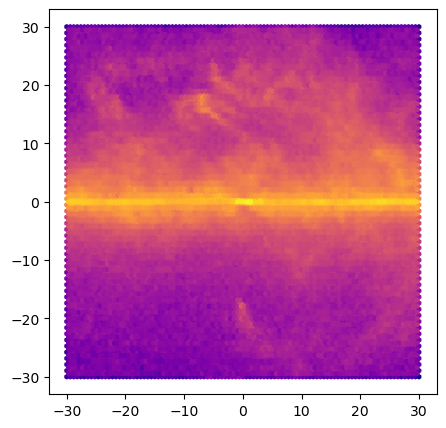

In [8]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)
s = ax.hexbin(simdata[:,1],
              simdata[:,0],gridsize=100,cmap='plasma',mincnt=1,bins='log')


In [10]:
# generate random point sources
# store locations and individual PS counts separately

In [9]:
#will train on a subregion:
thetamin = 5
thetamax = 25
phimin = +5
phimax = +25

emin = 1000
emax = 10000

test_mask = (simdata[:,1]>phimin)&(simdata[:,1]<phimax)&(simdata[:,0]>thetamin)&(simdata[:,0]<thetamax)&(simdata[:,2]>emin)&(simdata[:,2]<emax)

#number of PS
N_ps = 10
#expected number of photons in a PS
PS_lum = 400

#random locations of point sources
theta_loc = np.random.uniform(low = thetamin+2.5, high = thetamax-2.5, size=N_ps)
phi_loc = np.random.uniform(low = phimin+2.5, high = phimax-2.5, size=N_ps)

PS_loc = np.vstack([theta_loc.T,phi_loc.T]).T

In [10]:
#PSF for point sources (assumed to be constant, in degrees)
PS_PSF = 0.25
#PS energy center
PS_energy = 6000.
PS_energy_sigma = 2000.0

PS_counts = np.empty(0)

PS_elist = np.empty(0)
PS_loclist = np.empty( (0,2) )

In [11]:
for loc in PS_loc:
    e_temp = np.random.normal(loc=PS_energy,scale=PS_energy_sigma,size=PS_lum)
    loc_temp = np.random.normal(loc=loc,scale=PS_PSF,size=(PS_lum,2) )
    
    PS_elist = np.concatenate([PS_elist,e_temp])
    PS_loclist = np.concatenate([PS_loclist,loc_temp])
    
PS_data = np.vstack([PS_loclist.T,PS_elist.T]).T
    
PS_mask = (PS_loclist[:,1]>phimin)&(PS_loclist[:,1]<phimax)&(PS_loclist[:,0]>thetamin)&(PS_loclist[:,0]<thetamax)&(PS_elist>emin)&(PS_elist<emax)

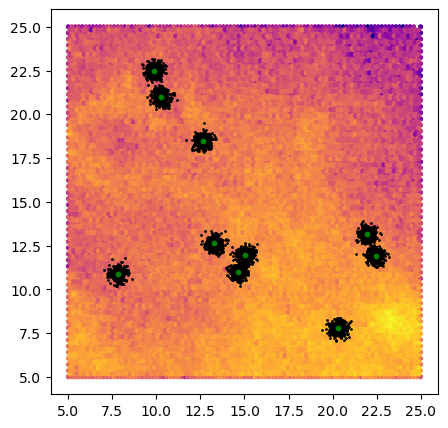

In [12]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

s = ax.hexbin(simdata[test_mask,1],
              simdata[test_mask,0],gridsize=100,cmap='plasma',mincnt=1,bins='log')

ax.scatter(PS_loclist[PS_mask,1],
           PS_loclist[PS_mask,0],c='k',s=1)


ax.scatter(PS_loc[:,1],
           PS_loc[:,0],c='g',s=10)


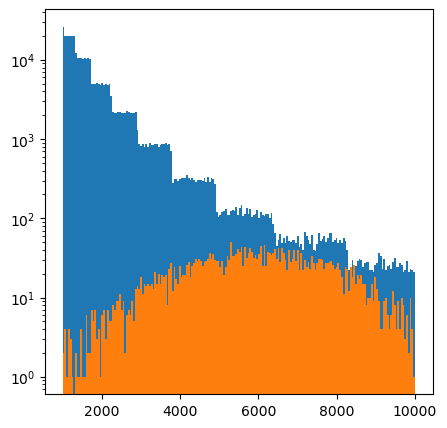

In [13]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

_,bins,_ = ax.hist(simdata[test_mask,2],bins=200)

_,_,_ = ax.hist(PS_data[:,2],bins=bins)

ax.set_yscale('log')

In [14]:
combined_data = np.concatenate([simdata,PS_data])
combined_data_mask = np.concatenate([test_mask,PS_mask])

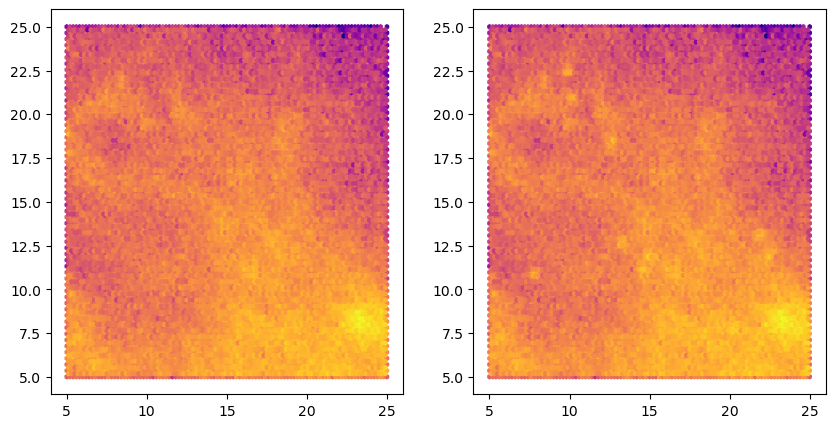

In [15]:
fig = plt.figure(1,figsize=(10,5))
ax = fig.add_subplot(121)

s = ax.hexbin(simdata[test_mask,1],
              simdata[test_mask,0],gridsize=100,cmap='plasma',mincnt=1,bins='log')

ax = fig.add_subplot(122)

s = ax.hexbin(combined_data[combined_data_mask,1],
              combined_data[combined_data_mask,0],gridsize=100,cmap='plasma',mincnt=1,bins='log')

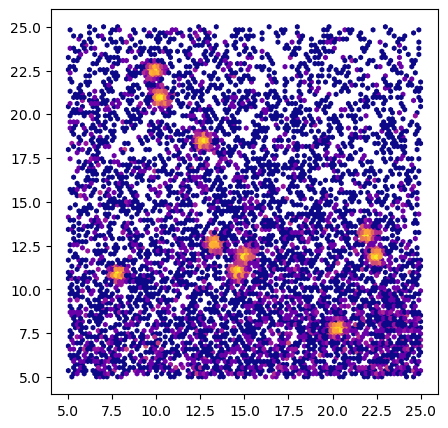

In [16]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

temp = combined_data[combined_data_mask]

s = ax.hexbin(temp[temp[:,2]>5000,1],
              temp[temp[:,2]>5000,0],gridsize=100,cmap='plasma',mincnt=1,bins='log')

In [94]:
# annulus point source detection algorithm

In [17]:
def annulus_sb(data,loc,inner_rad=2.0*PS_PSF,outer_rad=3.0*PS_PSF,energy_min=5.0e3,energy_max=7.0e3):
    data_mask = (data[:,2]>energy_min)&(data[:,2]<energy_max)
    
    distances = np.linalg.norm(data[data_mask,0:2]-loc,axis=1)
    S_area = np.pi*inner_rad**2
    B_area = np.pi*(outer_rad**2-inner_rad**2)
    
    S_mask = distances<inner_rad
    B_mask = (distances>inner_rad)&(distances<outer_rad)
    
    N = np.sum(S_mask)
    B = np.sum(B_mask)*S_area/B_area
    S = N-B
    
    return B,N,S,S/np.sqrt(B)

In [18]:
for i in range(len(PS_loc)):
    print(annulus_sb(combined_data,PS_loc[i]))

(32.8, 145, 112.2, 19.59096979633667)
(35.199999999999996, 140, 104.80000000000001, 17.664036396536947)
(13.600000000000001, 140, 126.4, 34.275012335347675)
(21.599999999999998, 143, 121.4, 26.121121012754468)
(23.2, 156, 132.8, 27.57109931144167)
(21.599999999999998, 143, 121.4, 26.121121012754468)
(32.8, 147, 114.2, 19.94018494422146)
(32.0, 148, 116.0, 20.506096654409877)
(22.4, 128, 105.6, 22.312072324832837)
(23.999999999999996, 131, 107.0, 21.841283539816672)


In [97]:
#plots of S/sqrt(B) for sources
#plots of S/sqrt(B) for all search locations

In [19]:
theta_testlocs = np.linspace(thetamin,thetamax,31)
phi_testlocs = np.linspace(phimin,phimax,31)

theta_mesh,phi_mesh = np.meshgrid(theta_testlocs,phi_testlocs)
test_mesh = np.zeros( (len(theta_testlocs),len(phi_testlocs),2) )
test_mesh[:,:,0] = theta_mesh
test_mesh[:,:,1] = phi_mesh
test_mesh = test_mesh.reshape(-1,2)

In [20]:
SsqrtB_loc = np.empty(0)

for i in range(len(PS_loc)):
    SsqrtB_loc = np.concatenate([SsqrtB_loc,[annulus_sb(combined_data[combined_data_mask],PS_loc[i])[-1]] ])

In [21]:
SsqrtB_all = np.empty(0)

for loc in test_mesh:
    SsqrtB_all = np.concatenate([SsqrtB_all,[annulus_sb(combined_data[combined_data_mask],loc)[-1]] ])

/tmp/ipykernel_3743427/4192872852.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  return B,N,S,S/np.sqrt(B)


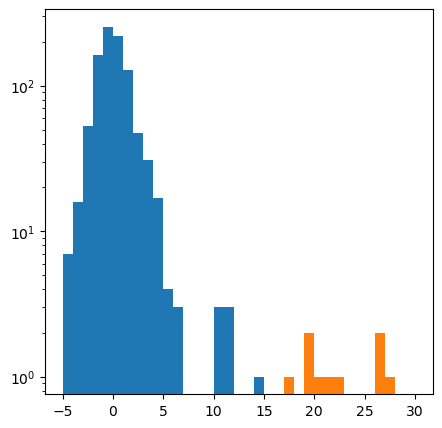

In [22]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

_,_,_ = ax.hist(SsqrtB_all,bins=np.linspace(-5,30,36))
_,_,_ = ax.hist(SsqrtB_loc,bins=np.linspace(-5,30,36))

ax.set_yscale('log')

In [7]:
#Training of MAF on pseudodata w/o PS

In [23]:
#np.save('fermi_test2_npPS.npy',simdata[test_mask])

configs = Configs(# data params:
                 DATA = 'FermiGCE_test2_noPS',
                 dataset = './fermi_test2_npPS.npy',
                 features = ['theta', 'phi', 'energy'],
                 preprocess = ['normalize', 'logit_transform', 'standardize'],
                 cuts = {'theta': [thetamin, thetamax], 'phi': [phimin, phimax], 'energy': [1000, 10000]},
                 data_split_fracs = [0.8, 0.2, 0.0],
                 # training params:
                 DEVICE = 'cuda:0',
                 EPOCHS = 10000,
                 batch_size = 15000,
                 print_epochs = 20,
                 early_stopping = 100,
                 min_epochs = 500,
                 lr = 1e-4,
                 optimizer = 'Adam',
                 fix_seed = None,
                 # dynamics params:
                 DYNAMICS = 'NormFlow',
                 permutation = 'reverse',
                 num_transforms = 10,
                 # model params:
                 num_blocks = 3,
                 dim_hidden = 256, 
                 dropout = 0.1,
                 num_bins = 40,
                 tail_bound = 10, 
                 use_residual_blocks = False,
                 use_batch_norm = False
                 )

In [28]:
#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define dataset:

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 

fermi = FermiDataset(configs)

maf = DynGenModelTrainer(dynamics = NormalizingFlow(configs), 
                         model = MAFPiecewiseRQS(configs), 
                         dataloader = FermiDataLoader(fermi, configs), 
                         configs = configs)

#============================================================================================
INFO: created directory: ../../results/FermiGCE_test2_noPS.NormFlow.MAF_RQS.2023.11.27_21h19
#============================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE_test2_noPS                             |
| dataset             | ./fermi_test2_npPS.npy                          |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [5, 25]                                  |
|                     | phi: [5, 25]                 

In [ ]:
#...train model:

maf.train()

number of training parameters: 3191639
start training...


epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

	Epoch: 1, train loss: 4.477540731430055, valid loss: 4.372815799713134  (min valid loss: 4.372815799713134)
	Epoch: 21, train loss: 4.145452308654786, valid loss: 4.158266830444336  (min valid loss: 4.157382583618164)
	Epoch: 41, train loss: 4.135823726654052, valid loss: 4.149379253387451  (min valid loss: 4.145832443237305)
	Epoch: 61, train loss: 4.130370235443115, valid loss: 4.141561889648437  (min valid loss: 4.141561889648437)
	Epoch: 81, train loss: 4.124938559532166, valid loss: 4.140339374542236  (min valid loss: 4.139954280853272)
	Epoch: 101, train loss: 4.1242307186126705, valid loss: 4.138952064514161  (min valid loss: 4.138303756713867)
	Epoch: 121, train loss: 4.118847775459289, valid loss: 4.1378563880920405  (min valid loss: 4.137154960632325)
	Epoch: 141, train loss: 4.120935869216918, valid loss: 4.1372706413269045  (min valid loss: 4.13665418624878)
	Epoch: 161, train loss: 4.120546984672546, valid loss: 4.1368909835815435  (min valid loss: 4.13627233505249)
	Epoc

In [24]:
model_workdir = '../../results/FermiGCE_test2_noPS.NormFlow.MAF_RQS.2023.11.27_21h19'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:0'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

fermi = FermiDataset(configs)
pretrained_maf = DynGenModelTrainer(dynamics = NormalizingFlow(configs),
                                    model = MAFPiecewiseRQS(configs),
                                    dataloader = FermiDataLoader(fermi, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_maf.load(model='best')

+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE_test2_noPS                             |
| dataset             | ./fermi_test2_npPS.npy                          |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [5, 25]                                  |
|                     | phi: [5, 25]                                    |
|                     | energy: [1000, 10000]                           |
| DEVICE              | cuda:0                                          |
| optimizer           | Adam                                            |
| lr                  | 0.0001        

In [25]:
pipeline_maf = NormFlowPipeline(trained_model=pretrained_maf, 
#                                configs=configs, 
                                preprocessor=PreProcessFermiData,
                                postprocessor=PostProcessFermiData,
#                                num_gen_samples=fermi.target.shape[0],
                                best_epoch_model=True)

# the new samples are called with the 'target' attribute:
pipeline_maf.generate_samples(num=fermi.target.shape[0])

print(pipeline_maf.target.shape)

torch.Size([362212, 3])


In [26]:
fermi.target.shape[0]

362212

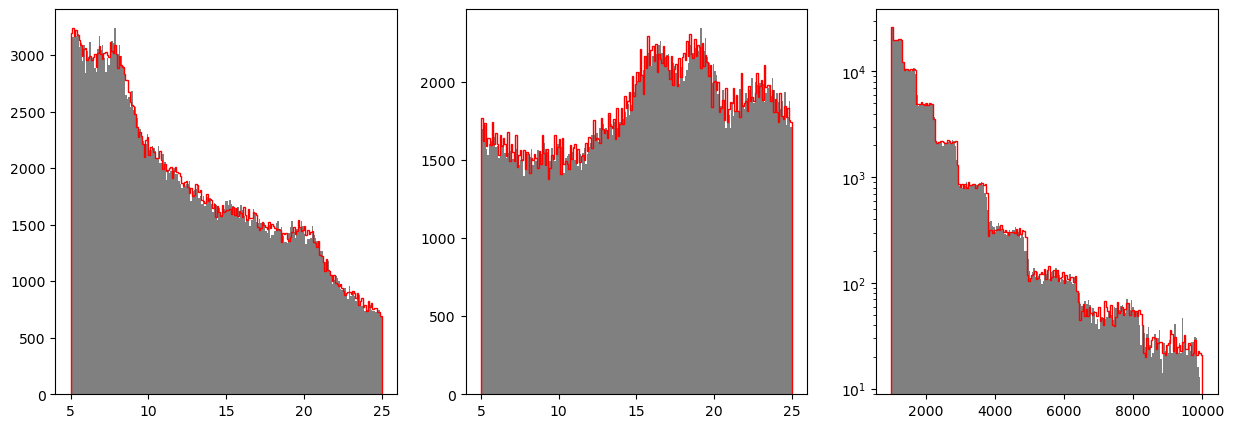

In [27]:
fig = plt.figure(1,figsize=(15,5))
ax = fig.add_subplot(131)

_,_,_ = ax.hist(pipeline_maf.target[:,0].detach().cpu().numpy(),bins=200,color='grey',density=False)
_,_,_ = ax.hist(fermi.target[:,0].detach().cpu().numpy(),bins=200,color='r',histtype='step',density=False)


ax = fig.add_subplot(132)

_,_,_ = ax.hist(pipeline_maf.target[:,1].detach().cpu().numpy(),bins=200,color='grey',density=False)
_,_,_ = ax.hist(fermi.target[:,1].detach().cpu().numpy(),bins=200,color='r',histtype='step',density=False)


ax = fig.add_subplot(133)

_,_,_ = ax.hist(pipeline_maf.target[:,2].detach().cpu().numpy(),bins=200,color='grey',density=False)
_,_,_ = ax.hist(fermi.target[:,2].detach().cpu().numpy(),bins=200,color='r',histtype='step',density=False)

ax.set_yscale('log')

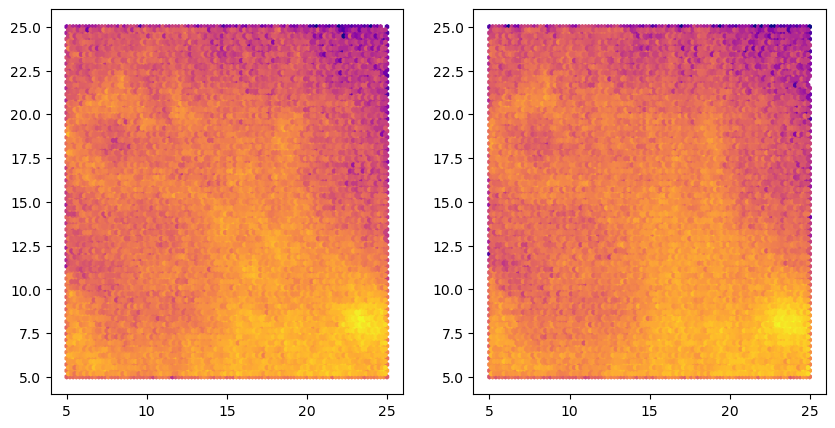

In [28]:
fig = plt.figure(1,figsize=(10,5))
ax = fig.add_subplot(121)

s = ax.hexbin(fermi.target[:,1].detach().cpu().numpy(),
              fermi.target[:,0].detach().cpu().numpy(),gridsize=100,cmap='plasma',mincnt=1,bins='log')

ax = fig.add_subplot(122)

s = ax.hexbin(pipeline_maf.target[:,1].detach().cpu().numpy(),
              pipeline_maf.target[:,0].detach().cpu().numpy(),gridsize=100,cmap='plasma',mincnt=1,bins='log')

In [48]:
#Training of MAF on pseudodata w/ PS

In [29]:
#np.save('fermi_test2_PS.npy',combined_data[combined_data_mask])

configs = Configs(# data params:
                 DATA = 'FermiGCE_test2_PS',
                 dataset = './fermi_test2_PS.npy',
                 features = ['theta', 'phi', 'energy'],
                 preprocess = ['normalize', 'logit_transform', 'standardize'],
                 cuts = {'theta': [thetamin, thetamax], 'phi': [phimin, phimax], 'energy': [1000, 10000]},
                 data_split_fracs = [0.8, 0.2, 0.0],
                 # training params:
                 DEVICE = 'cuda:0',
                 EPOCHS = 10000,
                 batch_size = 15000,
                 print_epochs = 20,
                 early_stopping = 100,
                 min_epochs = 500,
                 lr = 1e-4,
                 optimizer = 'Adam',
                 fix_seed = None,
                 # dynamics params:
                 DYNAMICS = 'NormFlow',
                 permutation = 'reverse',
                 num_transforms = 10,
                 # model params:
                 num_blocks = 3,
                 dim_hidden = 256, 
                 dropout = 0.1,
                 num_bins = 40,
                 tail_bound = 10, 
                 use_residual_blocks = False,
                 use_batch_norm = False
                 )

In [30]:
#...set working directory for results:

configs.set_workdir(path='../../results', save_config=True)

#...define dataset:

fermi_ps = FermiDataset(configs)

maf_ps = DynGenModelTrainer(dynamics = NormalizingFlow(configs), 
                         model = MAFPiecewiseRQS(configs), 
                         dataloader = FermiDataLoader(fermi_ps, configs), 
                         configs = configs)

#==========================================================================================
INFO: created directory: ../../results/FermiGCE_test2_PS.NormFlow.MAF_RQS.2023.11.28_19h42
#==========================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE_test2_PS                               |
| dataset             | ./fermi_test2_PS.npy                            |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [5, 25]                                  |
|                     | phi: [5, 25]                       

In [ ]:
#...train model:

maf_ps.train()

number of training parameters: 3191639
number of training parameters: 3191639
number of training parameters: 3191639
number of training parameters: 3191639
start training...
start training...
start training...
start training...


epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

	Epoch: 1, train loss: 4.397490215301514, valid loss: 4.300301170349121  (min valid loss: 4.300301170349121)
	Epoch: 1, train loss: 4.397490215301514, valid loss: 4.300301170349121  (min valid loss: 4.300301170349121)
	Epoch: 1, train loss: 4.397490215301514, valid loss: 4.300301170349121  (min valid loss: 4.300301170349121)
	Epoch: 1, train loss: 4.397490215301514, valid loss: 4.300301170349121  (min valid loss: 4.300301170349121)
	Epoch: 21, train loss: 4.144244265556336, valid loss: 4.151510429382324  (min valid loss: 4.151510429382324)
	Epoch: 21, train loss: 4.144244265556336, valid loss: 4.151510429382324  (min valid loss: 4.151510429382324)
	Epoch: 21, train loss: 4.144244265556336, valid loss: 4.151510429382324  (min valid loss: 4.151510429382324)
	Epoch: 21, train loss: 4.144244265556336, valid loss: 4.151510429382324  (min valid loss: 4.151510429382324)
	Epoch: 41, train loss: 4.1331412315368645, valid loss: 4.142858695983886  (min valid loss: 4.142858695983886)
	Epoch: 41, t

In [31]:
model_workdir = '../../results/FermiGCE_test2_PS.NormFlow.MAF_RQS.2023.11.28_14h42'
configs = Configs().load(model_workdir + '/config.json')
configs.DEVICE = 'cuda:0'   # select device
configs.workdir = model_workdir

#...be sure to use the same dataset, dataloader and model that was used for training the pre-trained model:

fermi_ps = FermiDataset(configs)
pretrained_maf_ps = DynGenModelTrainer(dynamics = NormalizingFlow(configs),
                                    model = MAFPiecewiseRQS(configs),
                                    dataloader = FermiDataLoader(fermi_ps, configs), 
                                    configs = configs)

#...load the pre-trained model:

pretrained_maf_ps.load(model='best')

+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| DATA                | FermiGCE_test2_PS                               |
| dataset             | ./fermi_test2_PS.npy                            |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [5, 25]                                  |
|                     | phi: [5, 25]                                    |
|                     | energy: [1000, 10000]                           |
| DEVICE              | cuda:0                                          |
| optimizer           | Adam                                            |
| lr                  | 0.0001        

In [32]:
print(pipeline_maf.target.shape)

torch.Size([362212, 3])


In [33]:
pipeline_maf_ps = NormFlowPipeline(trained_model=pretrained_maf_ps, 
#                                configs=configs, 
                                preprocessor=PreProcessFermiData,
                                postprocessor=PostProcessFermiData,
#                                num_gen_samples=fermi.target.shape[0],
                                best_epoch_model=True)

# the new samples are called with the 'target' attribute:
pipeline_maf_ps.generate_samples(num=fermi.target.shape[0])

print(pipeline_maf_ps.target.shape)

torch.Size([362212, 3])


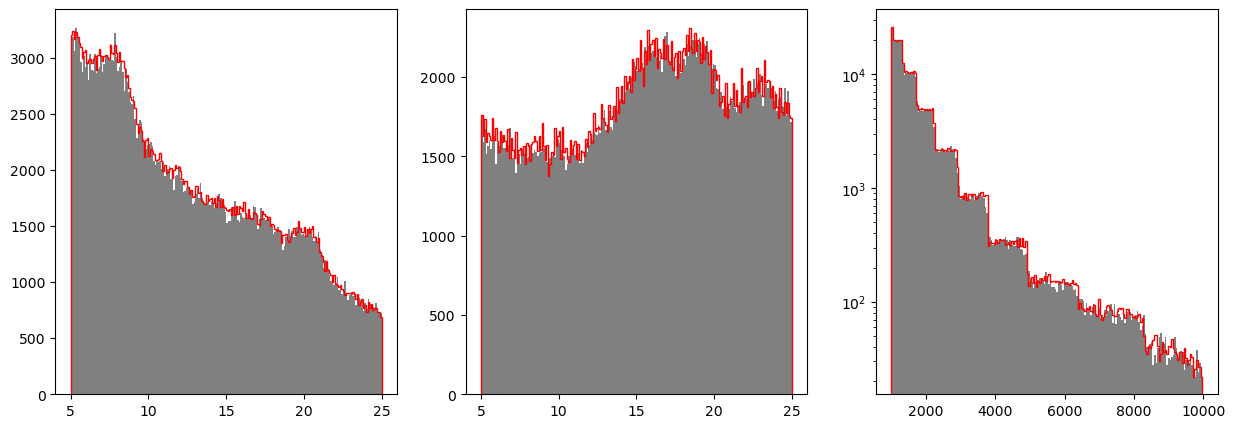

In [34]:
fig = plt.figure(1,figsize=(15,5))
ax = fig.add_subplot(131)

_,bins,_ = ax.hist(pipeline_maf_ps.target[:,0].detach().cpu().numpy(),bins=200,color='grey',density=False)
_,_,_ = ax.hist(fermi_ps.target[:,0].detach().cpu().numpy(),bins=bins,color='r',histtype='step',density=False)


ax = fig.add_subplot(132)

_,bins,_ = ax.hist(pipeline_maf_ps.target[:,1].detach().cpu().numpy(),bins=200,color='grey',density=False)
_,_,_ = ax.hist(fermi_ps.target[:,1].detach().cpu().numpy(),bins=bins,color='r',histtype='step',density=False)


ax = fig.add_subplot(133)

_,bins,_ = ax.hist(pipeline_maf_ps.target[:,2].detach().cpu().numpy(),bins=200,color='grey',density=False)
_,_,_ = ax.hist(fermi_ps.target[:,2].detach().cpu().numpy(),bins=bins,color='r',histtype='step',density=False)

ax.set_yscale('log')

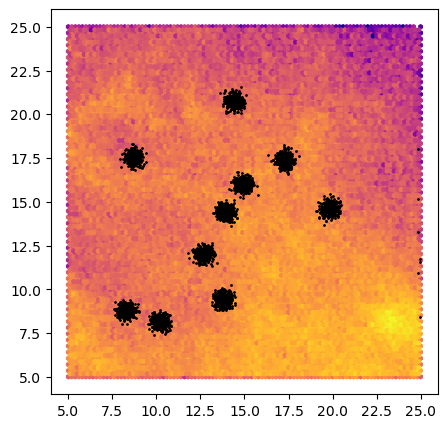

In [35]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

s = ax.hexbin(fermi_ps.target[:,1],
              fermi_ps.target[:,0],gridsize=100,cmap='plasma',mincnt=1,bins='log')


#ax.scatter(fermi_ps.target[:,1],
#           fermi_ps.target[:,0],c='g',s=10)

ax.scatter(fermi_ps.target[-3904:,1],
           fermi_ps.target[-3904:,0],c='k',s=1)

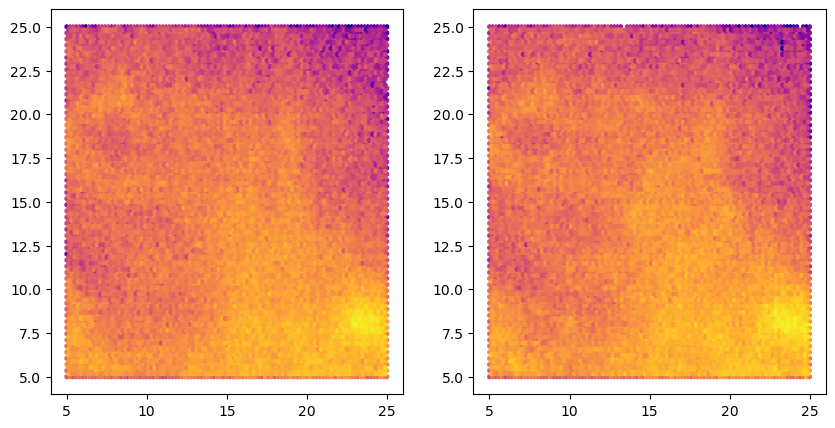

In [36]:
fig = plt.figure(1,figsize=(10,5))
ax = fig.add_subplot(121)

s = ax.hexbin(pipeline_maf.target[:,1].detach().cpu().numpy(),
              pipeline_maf.target[:,0].detach().cpu().numpy(),gridsize=100,cmap='plasma',mincnt=1,bins='log')

ax = fig.add_subplot(122)

s = ax.hexbin(pipeline_maf_ps.target[:,1].detach().cpu().numpy(),
              pipeline_maf_ps.target[:,0].detach().cpu().numpy(),gridsize=100,cmap='plasma',mincnt=1,bins='log')

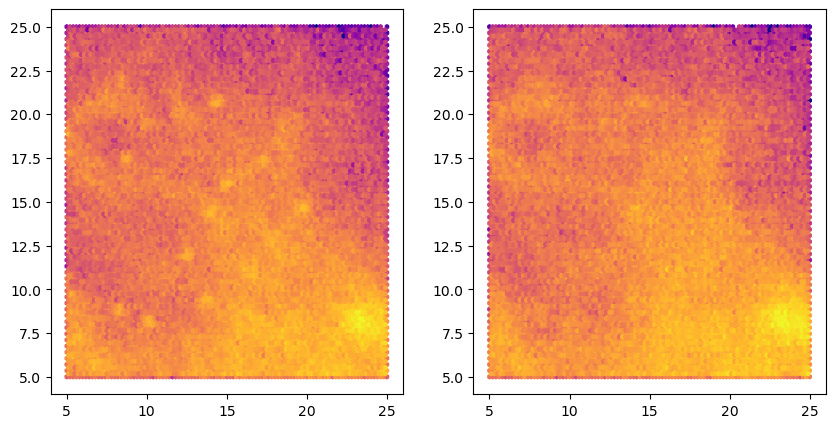

In [111]:
fig = plt.figure(1,figsize=(10,5))
ax = fig.add_subplot(121)

s = ax.hexbin(fermi_ps.target[:,1].detach().cpu().numpy(),
              fermi_ps.target[:,0].detach().cpu().numpy(),gridsize=100,cmap='plasma',mincnt=1,bins='log')

ax = fig.add_subplot(122)

s = ax.hexbin(pipeline_maf_ps.target[:,1].detach().cpu().numpy(),
              pipeline_maf_ps.target[:,0].detach().cpu().numpy(),gridsize=100,cmap='plasma',mincnt=1,bins='log')

In [51]:
maf_ll = pipeline_maf.log_prob(fermi_ps.target).detach().cpu().numpy()
maf_ps_ll = pipeline_maf_ps.log_prob(fermi_ps.target).detach().cpu().numpy()

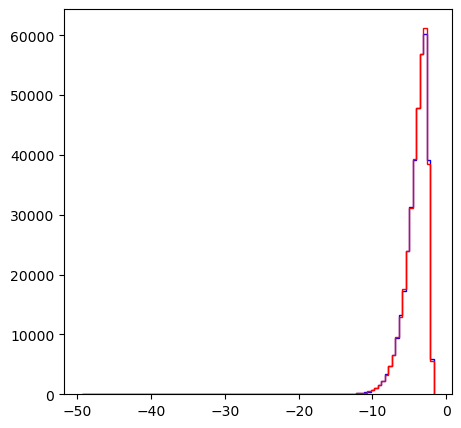

In [52]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

_,bins,_ = ax.hist(maf_ll,bins=100,histtype='step',color='b')
_,bins,_ = ax.hist(maf_ps_ll,bins=bins,histtype='step',color='r')

In [53]:
(maf_ps_ll-maf_ll)[-400:]

array([-1.25618935e-01, -1.94823742e-01,  8.03253651e-02,  2.62657642e-01,
        1.61981583e-02,  3.61828804e-02, -9.68799591e-02,  1.12884045e-01,
       -6.77537918e-03, -1.24619961e-01,  2.40600109e-01, -1.54244423e-01,
        2.04220772e-01,  1.49863720e-01,  1.12364769e-01, -1.59413338e-01,
       -1.16395950e-01, -1.17980003e-01,  4.27308083e-02,  9.46741104e-02,
        3.22165489e-02,  1.36973381e-01, -9.16452408e-02,  2.00526237e-01,
        1.47834301e-01,  1.24861240e-01,  1.06338024e-01,  2.48386860e-01,
        2.27952003e-02, -2.14424133e-02,  3.19946289e-01, -1.69641972e-01,
       -7.69486427e-02, -5.97567558e-02, -5.24644852e-02,  1.64321899e-01,
       -1.30082130e-01, -1.30703926e-01, -1.85113907e-01,  1.31474018e-01,
       -2.29472160e-01, -1.91274166e-01,  8.20667744e-02, -1.30850315e-01,
        6.46924973e-03, -1.59574509e-01, -2.52458572e-01, -1.73659325e-02,
        1.78315639e-01, -1.67720795e-01,  1.98508263e-01, -1.48037910e-01,
        2.89993286e-02,  

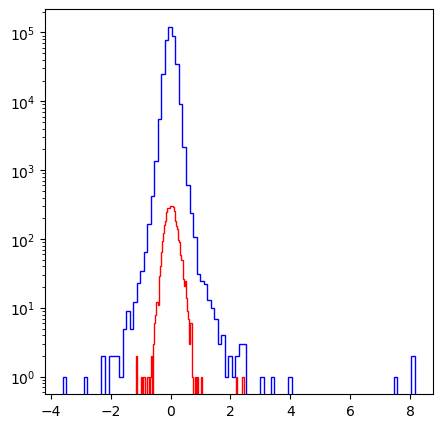

In [55]:
fig = plt.figure(1,figsize=(5,5))
ax = fig.add_subplot(111)

_,bins,_ = ax.hist(maf_ps_ll-maf_ll,bins=100,histtype='step',color='b')

_,bins,_ = ax.hist( (maf_ps_ll-maf_ll)[-3904:],bins=100,histtype='step',color='r')
ax.set_yscale('log')

In [9]:
#plots of ratios of phase space density between MAFwPS/MAFwoPS
#for all photons and for PS-photons

In [ ]:
pipeline = NormFlowPipeline(trained_model=pretrained_maf, 
                            preprocessor=PreProcessFermiData,
                            postprocessor=PostProcessFermiData,
                            best_epoch_model=True)

In [ ]:
pipeline.log_prob(input)


In [10]:
#plots of ratios of phase space density between high-E/low-E PS-photons in MAFwPS

In [ ]:
#cuts on anomaly-score R